[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aangelopoulos/conformal-prediction/blob/main/notebooks/weather-time-series-distribution-shift.ipynb)

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from tqdm import tqdm
from scipy.optimize import brentq
!pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [3]:
# Load cached data from Shifts (Yandex Weather Prediction). See https://github.com/Shifts-Project/shifts for details.
# The data has a change point halfway through.
if not os.path.exists('../data'):
    os.system('gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz')
    os.system('tar -xf ../data.tar.gz -C ../')
    os.system('rm ../data.tar.gz')

data = np.load('../data/weather/weather-catboost.npz')
preds = data['preds'][:,::1,:]
temperatures = data['temperatures'][::1] # Temperature (degrees Celsius)
times = data['times'][::1] # Times

pred_mean = preds[:,:,0].mean(axis=0)
pred_uncertainty = preds[:,:,1].mean(axis=0)

# Visualize the average accuracy
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

sort_idx = np.argsort(times)
pred_mean = pred_mean[sort_idx]
temperatures = temperatures[sort_idx]
times = times[sort_idx]
pred_uncertainty = pred_uncertainty[sort_idx]

In [4]:
# Problem setup
alpha = 0.1 # 1-alpha is the desired coverage
K=1000; weights = np.ones((K,)); # Take a fixed window of K
wtildes = weights/(weights.sum() + 1)

### Weighted conformal prediction happens here

In [5]:
# Use the uncertainty scalars method to get conformal scores
scores = np.abs(pred_mean-temperatures)/pred_uncertainty
# Get the weighted score quantile at each time step
def get_weighted_quantile(scores,T):
    score_window = scores[T-K:T]
    def critical_point_quantile(q): return (wtildes * (score_window <= q)).sum() - (1 - alpha)
    return brentq(critical_point_quantile, 0, 100)
qhats = np.array( [get_weighted_quantile(scores, t) for t in range(K+1, scores.shape[0])] )
# Deploy (output=lower and upper adjusted quantiles)
prediction_sets = [pred_mean[K+1:] - pred_uncertainty[K+1:]*qhats, pred_mean[K+1:] + pred_uncertainty[K+1:]*qhats]

In [6]:
# For comparison, run naive conformal
naive_qhats = np.array( [np.quantile(scores[:t], np.ceil((t+1)*(1-alpha))/t, interpolation='higher') for t in range(K+1, scores.shape[0]) ] )
naive_prediction_sets = [pred_mean[K+1:] - pred_uncertainty[K+1:]*naive_qhats, pred_mean[K+1:] + pred_uncertainty[K+1:]*naive_qhats]

In [7]:
# Calculate coverage over time
covered = ( temperatures[K+1:] >= prediction_sets[0] ) & ( temperatures[K+1:] <= prediction_sets[1] )
coverage_over_time = moving_average(covered, 500)
naive_covered = ( temperatures[K+1:] >= naive_prediction_sets[0] ) & ( temperatures[K+1:] <= naive_prediction_sets[1] )
naive_coverage_over_time = moving_average(naive_covered, 500)

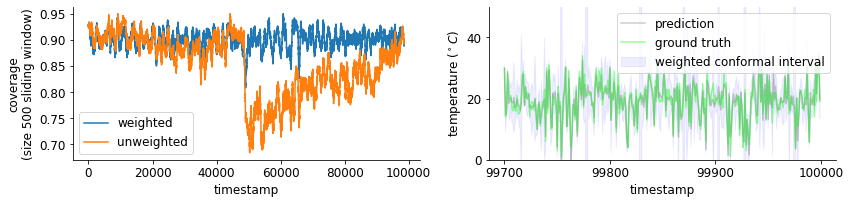

In [8]:
# Plot prediction sets and coverage over time
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(1,2,figsize=(12,3))

axs[0].plot(coverage_over_time, label='weighted');
axs[0].plot(naive_coverage_over_time, label='unweighted');
sns.despine(ax=axs[0],top=True,right=True)
axs[0].set_xlabel('timestamp')
axs[0].set_ylabel(f'coverage\n(size 500 sliding window)')
axs[0].legend()

start_point = 99700
timestamps = np.array(range(start_point,pred_mean[K+1:].shape[0]+K+1))
axs[1].plot(timestamps,pred_mean[start_point:],color='#00000033',label='prediction')
axs[1].plot(timestamps,temperatures[start_point:],color='#00FF0066', label='ground truth')
sns.despine(ax=axs[1],top=True,right=True)
axs[1].fill_between(timestamps, prediction_sets[0][start_point-K-1:], prediction_sets[1][start_point-K-1:], color='#0000FF11', label='weighted conformal interval');
axs[1].set_ylim(0,50);
axs[1].locator_params(tight=True, nbins=4)
axs[1].set_xlabel('timestamp')
axs[1].set_ylabel(r'temperature ($^\circ C$)')
axs[1].legend(loc='upper right');
plt.tight_layout()

plt.savefig('../data/weather/weather-results.pdf',)

This method was first introduced here: https://arxiv.org/abs/2202.13415.